In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from abc import abstractmethod
import scipy as sc
from ydata_profiling import ProfileReport
from scipy import stats as sts
import sklearn 
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, fbeta_score, precision_recall_curve, average_precision_score, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import phik
from typing import Literal
from sklearn.compose import ColumnTransformer
import umap
from catboost import CatBoostClassifier
import optuna
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn  # Если нужно логировать модели sklearn
mlflow.set_tracking_uri("http://127.0.0.1:5000")
import os
from mlflow.models import infer_signature
mlflow.set_experiment("multiclass_experiment")  
pd.options.display.max_columns = None
sklearn.set_config(transform_output='pandas')
%matplotlib

2025/03/02 16:15:04 INFO mlflow.tracking.fluent: Experiment with name 'multiclass_experiment' does not exist. Creating a new experiment.


Using matplotlib backend: module://matplotlib_inline.backend_inline


In [6]:
import mlflow
print(mlflow.get_tracking_uri())  # Проверяем текущий URI


http://127.0.0.1:5000


In [11]:
df = pd.read_csv('data/star_classification.csv')
df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [12]:
df = df.drop(columns='obj_ID')

In [13]:
df

,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [14]:
df = df.iloc[range(1000)]

In [15]:
df['rerun_ID'].unique()

array([301])

In [16]:
df = df.drop(columns='rerun_ID')

In [17]:
df.describe()

,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,188.196554,21.586807,22.351454,20.853220,19.792843,19.158799,18.805202,4991.107000,3.40800,176.386000,6.017714e+18,0.575877,5344.695000,55732.153000,443.299000
std,111.212541,16.961510,2.181603,1.974278,1.838924,1.712725,1.739727,2154.765041,1.26931,122.338308,3.242804e+18,0.668282,2880.176758,1741.589877,269.861529
min,0.024258,-8.299666,15.698960,14.301950,13.457930,13.036150,12.397260,1140.000000,1.00000,11.000000,3.671157e+17,-0.003844,326.000000,51692.000000,3.000000
25%,127.897674,7.496291,20.714630,19.399168,18.375160,17.902762,17.586025,3606.000000,2.00000,87.000000,3.660086e+18,0.096839,3250.750000,54882.000000,212.750000
50%,179.794305,20.339265,22.487220,21.401505,20.274695,19.488050,19.047115,4263.000000,4.00000,147.000000,5.683601e+18,0.466113,5048.000000,55945.500000,412.500000
75%,254.658698,32.162116,23.997467,22.297863,21.082223,20.403685,19.851915,7717.000000,4.00000,232.000000,8.527976e+18,0.694190,7574.250000,56944.000000,643.000000
max,359.946316,68.121576,27.368430,25.681880,24.802600,23.178280,23.990340,8157.000000,6.00000,819.000000,1.412684e+19,5.922225,12547.000000,58932.000000,1000.000000


In [18]:
df.isna().sum()

alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

In [19]:
df.dtypes

alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID           int64
cam_col          int64
field_ID         int64
spec_obj_ID    float64
class           object
redshift       float64
plate            int64
MJD              int64
fiber_ID         int64
dtype: object

In [20]:
df['class'].unique()

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [21]:
# profile = ProfileReport(df)
# profile.to_file('stellar_report.html')

In [22]:
df[df['z'] == -9999]

,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID


In [23]:
df[df['u'] == -9999]

,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID


In [24]:
ord = OrdinalEncoder()

df[['class']] = ord.fit_transform(df[['class']])

In [25]:
X = df.drop(columns='class')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

[I 2025-03-02 16:27:23,933] A new study created in memory with name: no-name-bfeeb680-028f-44fa-ae55-5d0252e0aadf
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/

🏃 View run enchanting-trout-858 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/076b0c2a7ac747c980d2dad6b3228436
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run rebellious-crow-813 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/9d28749237944d0a9c2271cdc70679d5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run resilient-robin-627 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/95497484a3b24a3cb9a73dcb99ceb4e7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run dazzling-tern-654 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/e2ee13f92fc840f2aeb65935ecfab251
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run invincible-tern-15 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/e42075b1e69b4d098b83f3d0be2c343c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run funny-shrew-734 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/55e4db1a56bf47349421bee6978761de
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run placid-grub-200 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/8792706c8c3d4c478341bd30f0e0ffb1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run suave-duck-647 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/19a2ff1890a84ba5abf3c0e73bad7cc7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run gentle-turtle-515 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/82c9e636b5774e3f866b70634b579a1c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run victorious-sloth-759 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/4c0a4d5da1fa4662b2f173d0a4cea35d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run dazzling-hen-964 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/219cd89f34a24761859fc79f0fd5930e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run casual-fly-545 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/0e670dd413ab4c3b9006a9dd0347ef35
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run powerful-moth-440 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/e7760be9ff5e4c9bb5c7165037f9596b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run salty-duck-240 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/1a5929c0e6bb41fb95df8e82c8f7e12b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run industrious-calf-811 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/7095df0795d0478198bf62b933c4384a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer co

🏃 View run luminous-skunk-658 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/7b7ce7953c9a4becb13c720fe178ed98
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

🏃 View run amazing-calf-426 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/04ed8cf7aeee4c4fb843bb0b4d858bc3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

🏃 View run bouncy-perch-189 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/08569bb45b004cb898a7234f046a0412
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

🏃 View run unruly-horse-374 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/b519a5484e114646a2e32b435f61c874
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

🏃 View run carefree-gull-691 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/efe02e27dba5439ea53f797fe9d62bdc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

🏃 View run unruly-rat-58 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/9aa46d79e06a41d1b37b4a4f8188c81d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

🏃 View run auspicious-asp-184 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/37765b1d094047e8a741bfb6a82700b6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

🏃 View run adorable-carp-163 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/c52c44f932ee4d929b3e8e5642dea2df
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

🏃 View run victorious-bass-282 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/5e5b8109c7244dc0938d72c5763d98f7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

🏃 View run victorious-moose-876 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/82958dca635240fe9257df7c54d4f934
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

🏃 View run upset-fawn-302 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/ae6f3c4f5e884d72a6923197771bcc49
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

🏃 View run enthused-lynx-966 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/054209821bb4483a984508aa6a8dd350
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

🏃 View run orderly-seal-367 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/b7376a8dc6924ae8b587a28b6431a4a9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

🏃 View run welcoming-moth-174 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/2e6f2b4cd18540a5867b66ac203503a3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754


/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

🏃 View run bemused-loon-74 at: http://127.0.0.1:5000/#/experiments/457936710379911754/runs/cef727b1aa054d36b6df5f6d756b4773
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457936710379911754
Best pipeline: {'model': 'xgb', 'learning_rate': 0.1727659702007661, 'max_depth': 3, 'reg_alpha': 0.18584756113149026, 'reg_lambda': 0.9280374554052289}


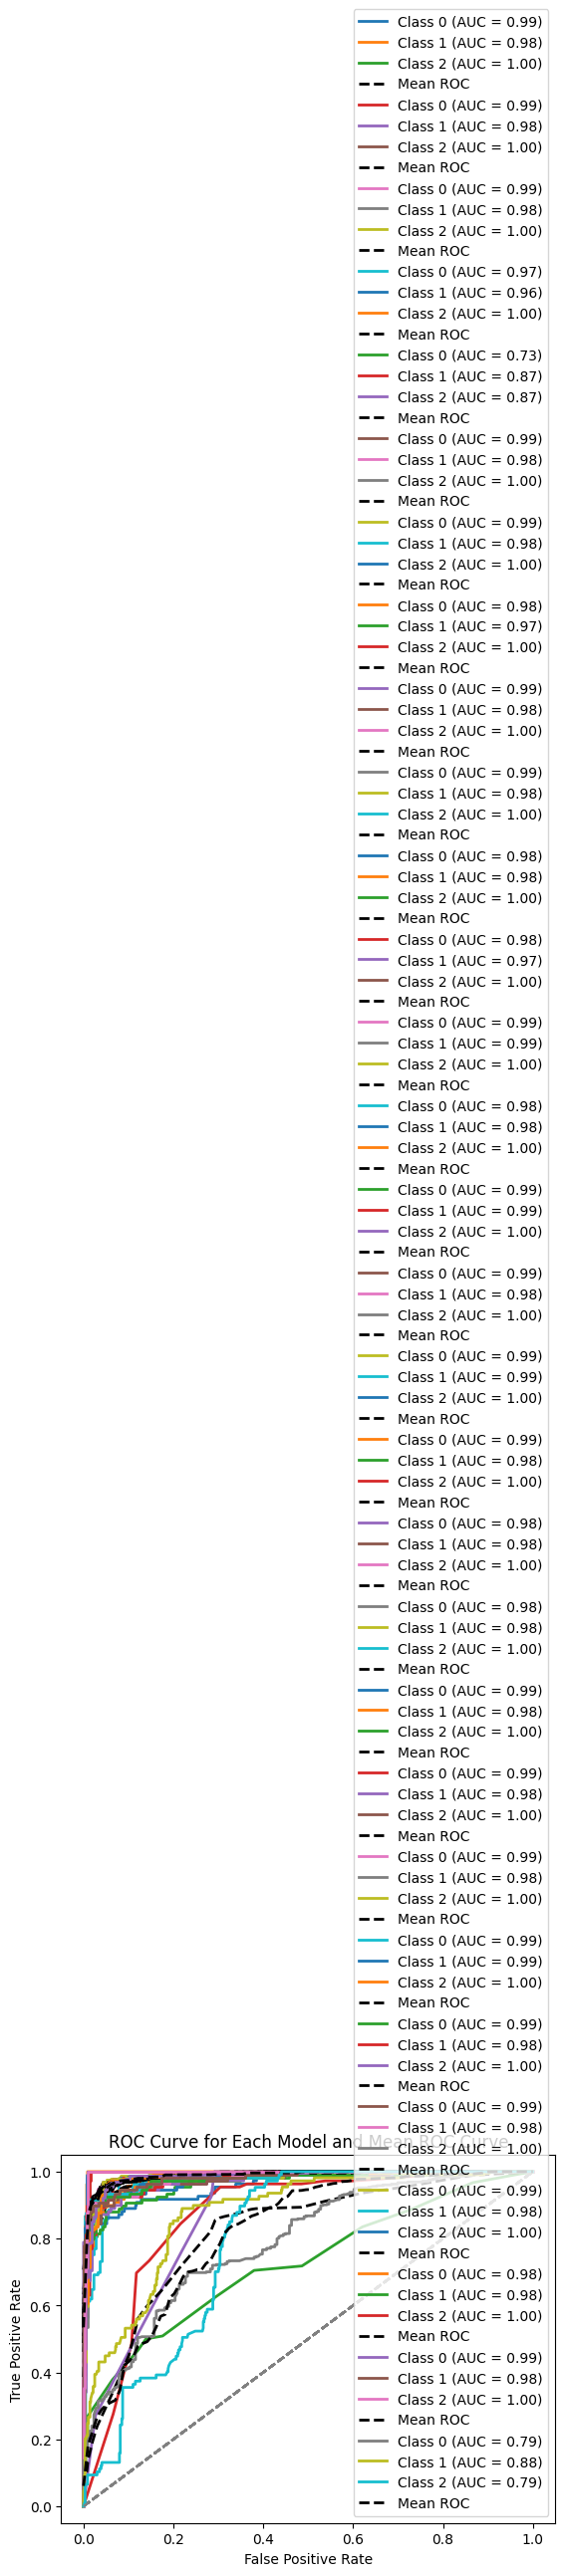

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import optuna

def objective(trial):
    
    with mlflow.start_run():

        scaler = PowerTransformer()
            
        model = trial.suggest_categorical('model', ['xgb', 'catboost', 'RandomForest'])
        
        if model == 'xgb':
            model = OneVsRestClassifier(XGBClassifier(
                n_estimators = 300,
                learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3),
                max_depth = trial.suggest_int('max_depth', 1, 10),
                reg_alpha = trial.suggest_float('reg_alpha', 0.1, 4),
                reg_lambda = trial.suggest_float('reg_lambda', 0.01, 1)
            ))
            
        elif model == 'catboost':
            model = OneVsRestClassifier(CatBoostClassifier(verbose=0))
        else:
            model = OneVsRestClassifier(RandomForestClassifier(
                criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
                max_depth = trial.suggest_int('max_depth', 1, 30),
                min_samples_split = trial.suggest_int('min_samples_split', 2, 15),
                min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20),
                min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.00001, 0.5),
                max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 3, 200),
                n_estimators = trial.suggest_int('n_estimators', 2, 1000),
                bootstrap = trial.suggest_categorical('bootstrap', [True, False])
            ))
            
        pipeline = Pipeline([
            ("scaler", scaler),
            ("model", model)
        ])
        
        mlflow.log_params(trial.params)
        # Получаем предсказания для каждой модел
        # и через кросс-валидацию
        y_pred_prob = cross_val_predict(pipeline, X_train, y_train, cv=3, method='predict_proba')

        # Рисуем ROC-кривую для каждой модели
        n_classes = y_train.nunique()  # Получаем количество классов
        fpr_dict = {}
        tpr_dict = {}   
        roc_auc_dict = {}
        
        for i in range(n_classes):
            # Вычисляем fpr и tpr для каждого класса
            fpr, tpr, _ = roc_curve((y_train == i).astype(int), y_pred_prob[:, i])
            roc_auc = auc(fpr, tpr)
            
            # Сохраняем ROC-значения для каждой модели
            fpr_dict[i] = fpr
            tpr_dict[i] = tpr
            roc_auc_dict[i] = roc_auc
            
            mlflow.log_metric(f"auc_class_{i}", roc_auc)
    
    
            plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.zeros_like(mean_fpr)
        
        for i in range(n_classes):
            mean_tpr += np.interp(mean_fpr, fpr_dict[i], tpr_dict[i])
        
        mean_tpr /= n_classes
        
        plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', lw=2, label='Mean ROC')

        plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Each Model and Mean ROC Curve')
        plt.legend(loc='lower right')


        score = cross_val_score(pipeline, X_train, y_train, cv=3, scoring="roc_auc_ovr").mean()
        
        input_example = X_train.iloc[:1] if hasattr(X_train, "iloc") else np.array(X_train[:1])

        mlflow.sklearn.log_model(pipeline, "model", input_example=input_example)
        
        if score > 0.8:
            plt.savefig("roc_curve.png")
            mlflow.log_artifact("roc_curve.png")
            os.remove("roc_curve.png")
        
        return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Лучший результат
print("Best pipeline:", study.best_params)


[I 2025-02-26 19:00:44,274] A new study created in memory with name: no-name-2810597a-6827-415b-8d3b-4cb97e812f7c
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


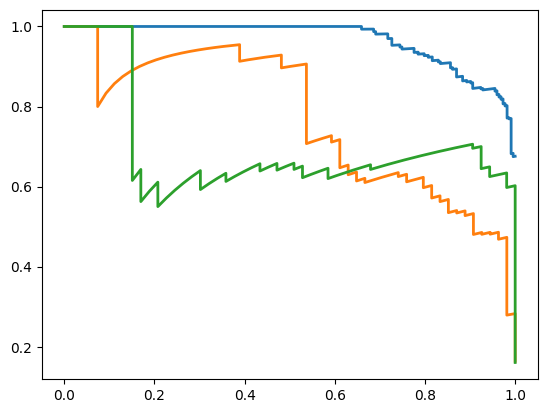

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:00:50,980] Trial 0 finished with value: 0.9300259954199119 and parameters: {'model': 'RandomForest', 'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.2223664641405979, 'max_features': 'sqrt', 'max_leaf_nodes': 181, 'n_estimators': 699, 'bootstrap': False}. Best is trial 0 with value: 0.9300259954199119.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: o

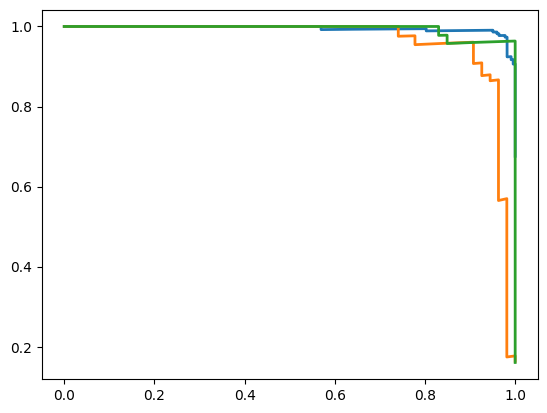

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:01:07,715] Trial 1 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=

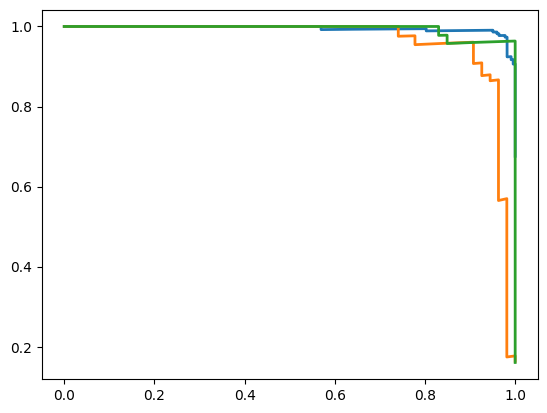

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:01:25,202] Trial 2 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=

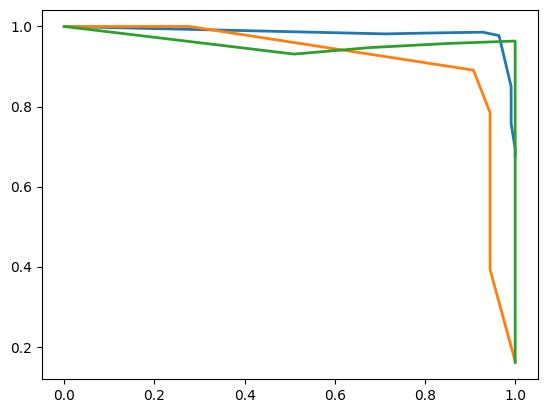

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:01:36,276] Trial 3 finished with value: 0.9667729515634251 and parameters: {'model': 'RandomForest', 'criterion': 'log_loss', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 17, 'min_weight_fraction_leaf': 0.15977379063543853, 'max_features': None, 'max_leaf_nodes': 127, 'n_estimators': 567, 'bootstrap': False}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: 

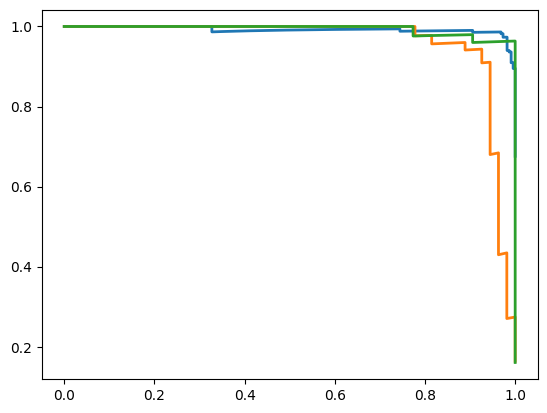

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:01:37,542] Trial 4 finished with value: 0.989040877314859 and parameters: {'model': 'xgb', 'learning_rate': 0.20251885888280896, 'max_depth': 8, 'reg_alpha': 0.11024396273905737, 'reg_lambda': 0.33549326116296524}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/si

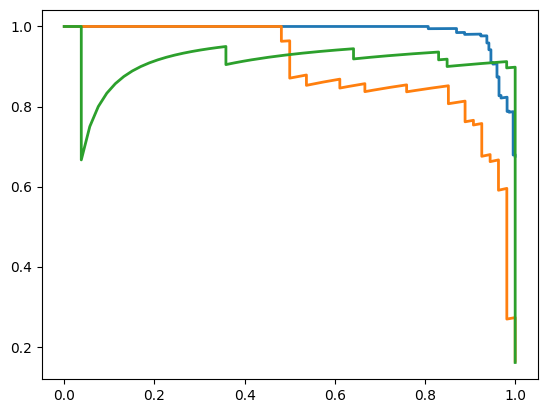

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:01:38,229] Trial 5 finished with value: 0.9654476653214673 and parameters: {'model': 'RandomForest', 'criterion': 'log_loss', 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 16, 'min_weight_fraction_leaf': 0.17224326808287738, 'max_features': 'sqrt', 'max_leaf_nodes': 118, 'n_estimators': 51, 'bootstrap': False}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning:

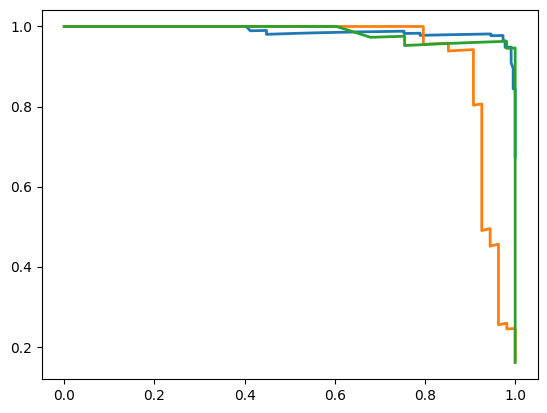

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:01:39,537] Trial 6 finished with value: 0.9854443355193468 and parameters: {'model': 'xgb', 'learning_rate': 0.08337478360554673, 'max_depth': 10, 'reg_alpha': 3.3683197729855037, 'reg_lambda': 0.40227958985478296}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/s

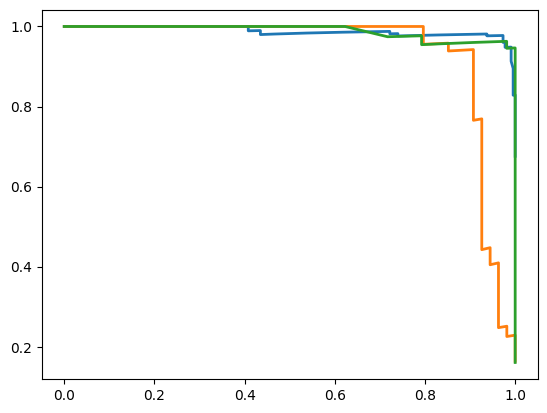

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:01:41,454] Trial 7 finished with value: 0.9860586560909398 and parameters: {'model': 'xgb', 'learning_rate': 0.02427420011212492, 'max_depth': 5, 'reg_alpha': 3.5813138095548207, 'reg_lambda': 0.3349757082927111}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/sit

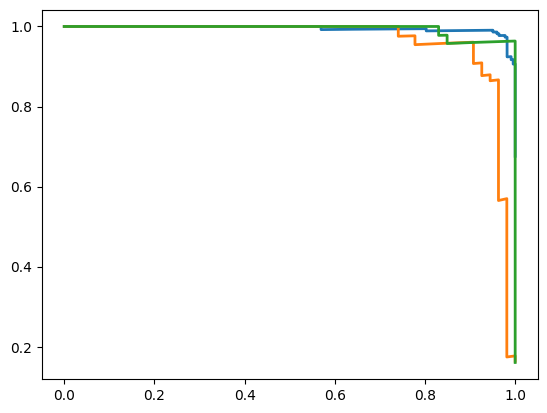

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:01:59,019] Trial 8 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=

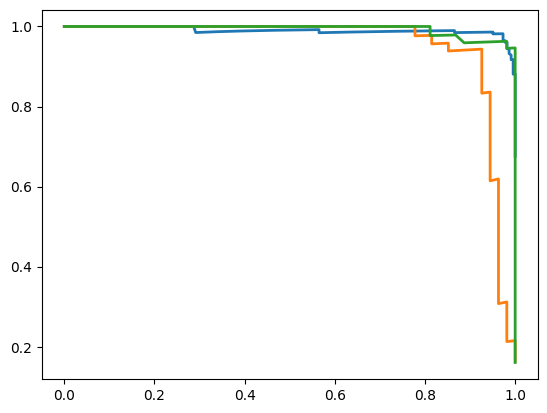

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:02:00,868] Trial 9 finished with value: 0.987465433835078 and parameters: {'model': 'xgb', 'learning_rate': 0.13767145739021194, 'max_depth': 8, 'reg_alpha': 2.153285457187134, 'reg_lambda': 0.09123958529379741}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site

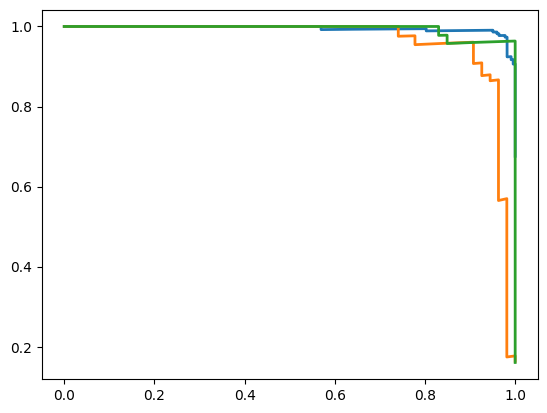

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:02:18,647] Trial 10 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

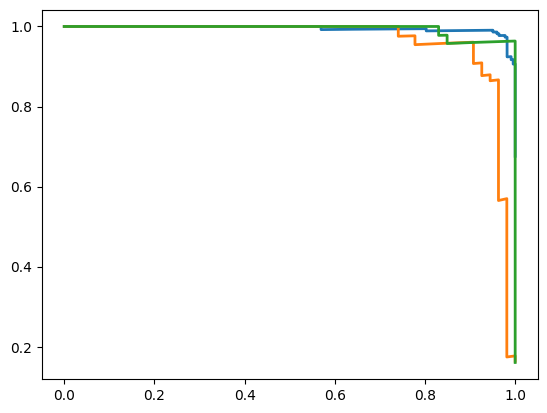

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:02:36,531] Trial 11 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

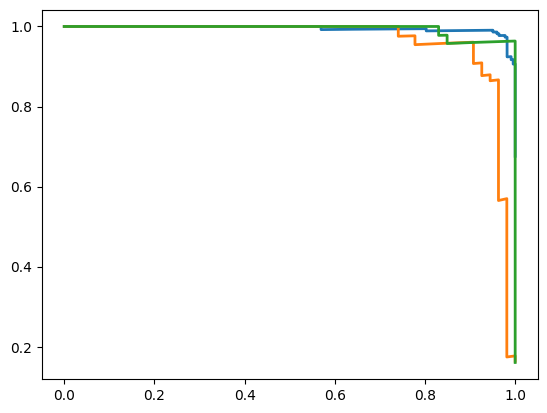

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:02:54,486] Trial 12 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

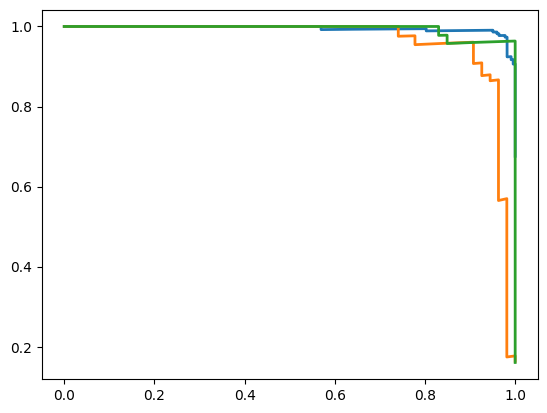

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:03:12,572] Trial 13 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

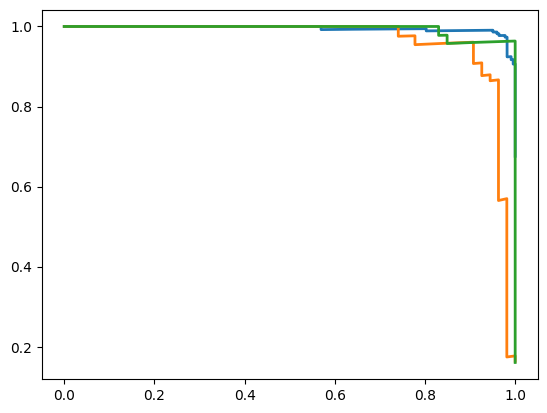

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:03:30,978] Trial 14 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

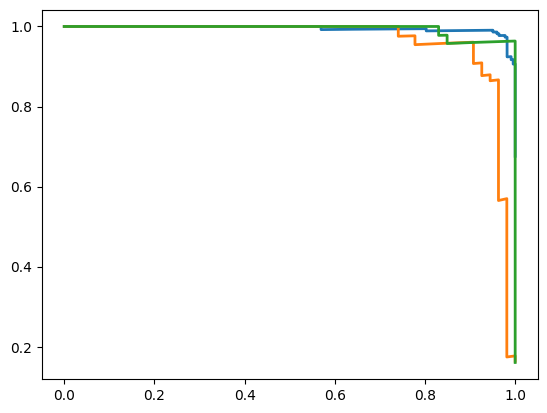

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:03:49,424] Trial 15 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

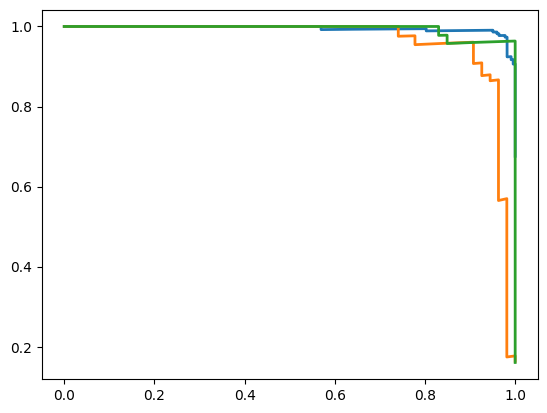

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:04:07,629] Trial 16 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

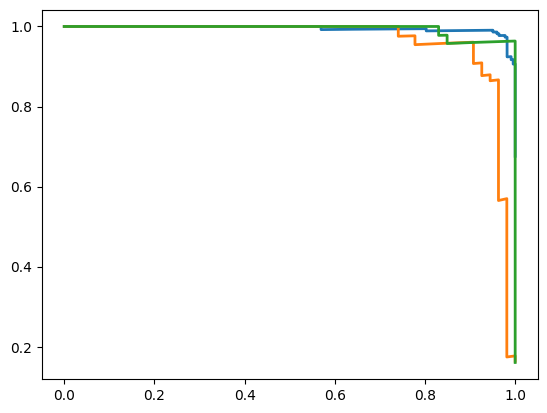

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:04:25,874] Trial 17 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

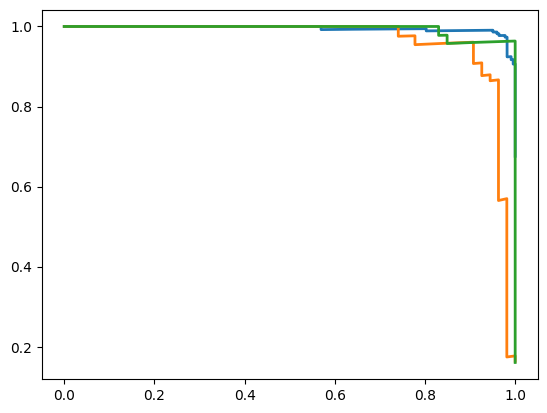

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:04:44,136] Trial 18 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

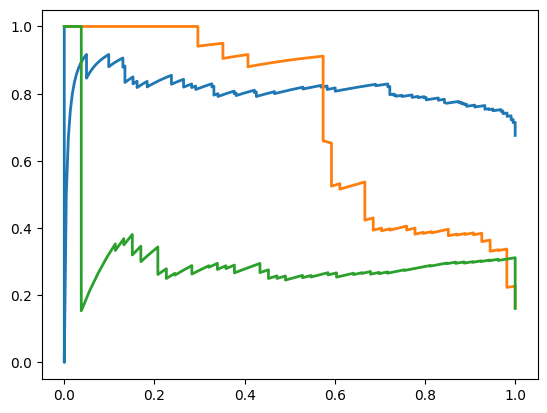

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:04:54,571] Trial 19 finished with value: 0.8004197224846435 and parameters: {'model': 'RandomForest', 'criterion': 'gini', 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.4937644283324586, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 996, 'bootstrap': True}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overf

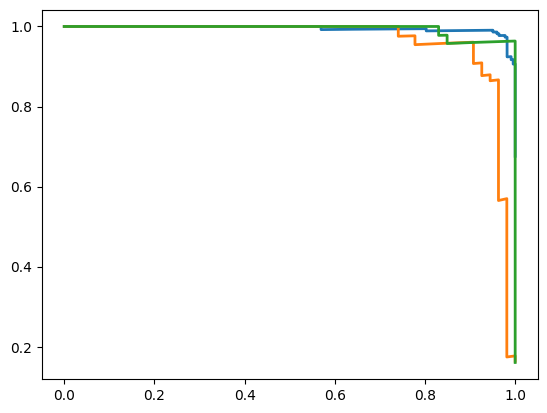

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:05:12,735] Trial 20 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

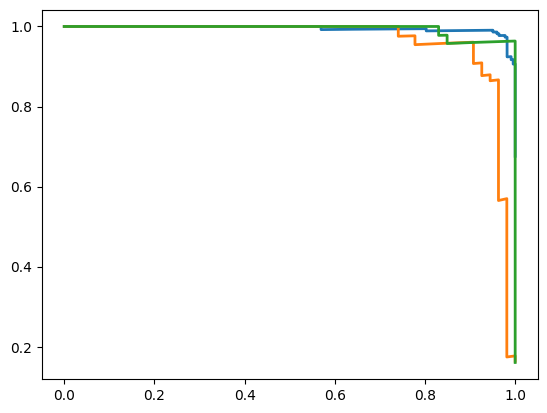

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:05:30,822] Trial 21 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

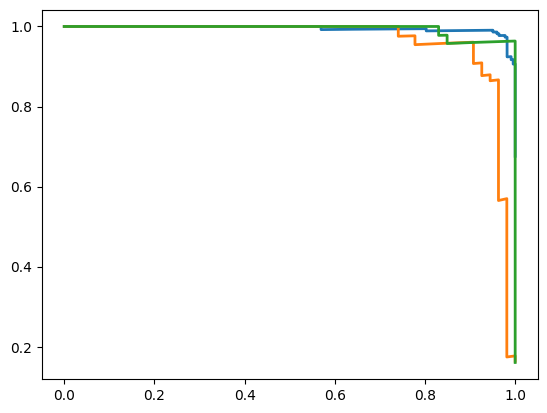

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:05:49,678] Trial 22 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

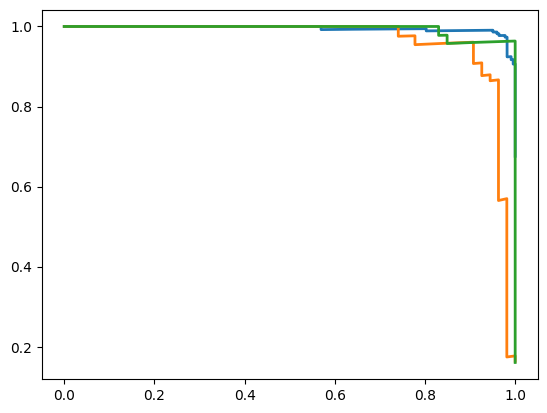

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:06:08,614] Trial 23 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

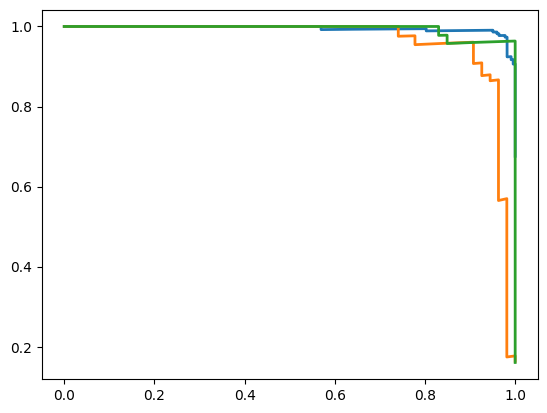

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:06:27,800] Trial 24 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

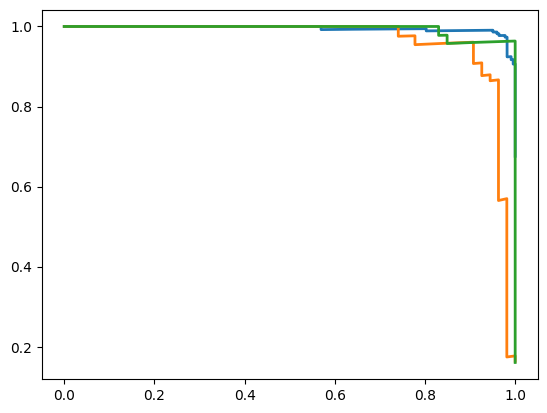

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:06:47,554] Trial 25 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

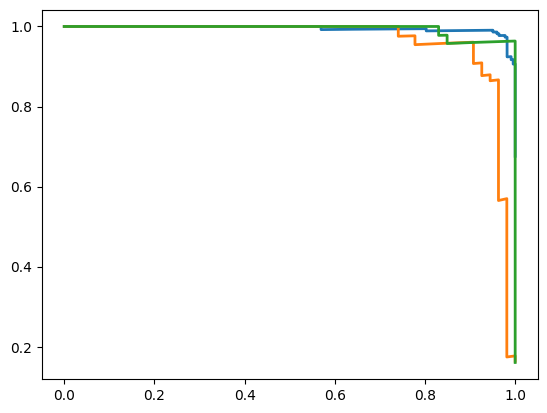

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:07:09,542] Trial 26 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

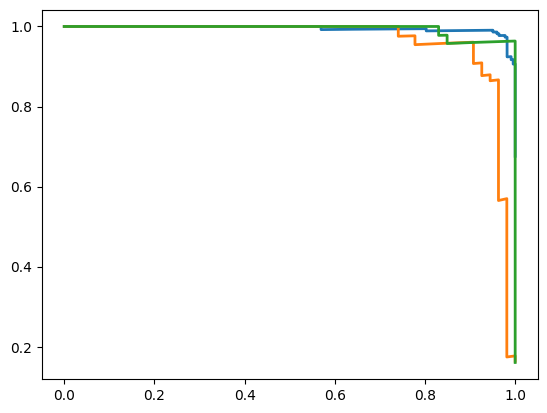

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:07:30,417] Trial 27 finished with value: 0.9892221808249014 and parameters: {'model': 'catboost'}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out

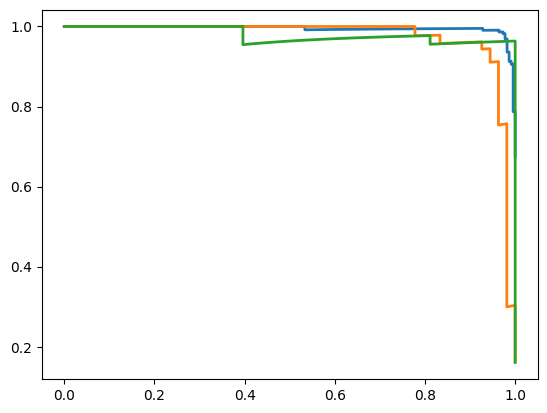

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:07:31,904] Trial 28 finished with value: 0.9890986022050234 and parameters: {'model': 'xgb', 'learning_rate': 0.2864951153474722, 'max_depth': 1, 'reg_alpha': 0.35472904489379276, 'reg_lambda': 0.9500018064493684}. Best is trial 1 with value: 0.9892221808249014.
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/si

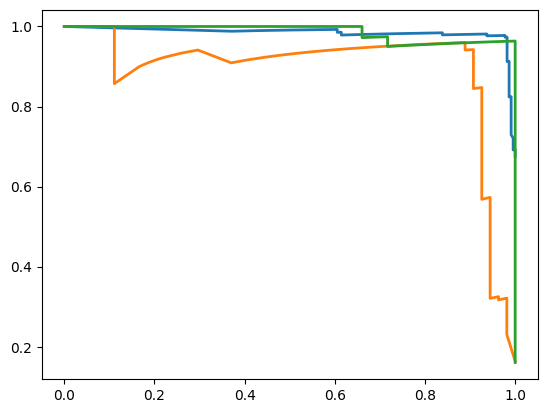

/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/envs/multiclass/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[I 2025-02-26 19:07:32,947] Trial 29 finished with value: 0.9803786333991852 and parameters: {'model': 'RandomForest', 'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 15, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.0021903144390805485, 'max_features': None, 'max_leaf_nodes': 20, 'n_estimators': 32, 'bootstrap': True}. Best is trial 1 with value: 0.9892221808249014.


Best pipeline: {'model': 'catboost'}


In [90]:
def objective(trial):

    scaler = PowerTransformer()
        
    model = trial.suggest_categorical('model', ['xgb', 'catboost', 'RandomForest'])
    
    if model == 'xgb':
        model = OneVsRestClassifier(XGBClassifier(
            n_estimators = 300,
            learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3),
            max_depth = trial.suggest_int('max_depth', 1, 10),
            reg_alpha = trial.suggest_float('reg_alpha', 0.1, 4),
            reg_lambda = trial.suggest_float('reg_lambda', 0.01, 1)
        ))
        
    elif model == 'catboost':
        model = OneVsRestClassifier(CatBoostClassifier(verbose=0))
        
    else:
        model = OneVsRestClassifier(RandomForestClassifier(
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
            max_depth = trial.suggest_int('max_depth', 1, 30),
            min_samples_split = trial.suggest_int('min_samples_split', 2, 15),
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20),
            min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.00001, 0.5),
            max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 3, 200),
            n_estimators = trial.suggest_int('n_estimators', 2, 1000),
            bootstrap = trial.suggest_categorical('bootstrap', [True, False])
        ))
        
    pipeline = Pipeline([
        ("scaler", scaler),
        ("model", model)
    ])
    
    # Получаем предсказания для каждой модели через кросс-валидацию
    y_pred_prob = cross_val_predict(pipeline, X_test, y_test, cv=3, method='predict_proba')

    # Рисуем ROC-кривую для каждой модели
    n_classes = y_train.nunique()  # Получаем количество классов
    pr = {}
    rc = {}
    
    for i in range(n_classes):
        # Вычисляем fpr и tpr для каждого класса
        
        precision, recall, _ = precision_recall_curve(y_test == i, y_pred_prob[:, i])
        
        # Сохраняем ROC-значения для каждой модели
        pr[i] = precision
        rc[i] = recall
        
        # Рисуем ROC-кривую для каждого класса
        plt.plot(recall, precision, lw=2, label=f'Class {i}')
        
    plt.show()

    # Оценка модели с использованием ROC AUC
    score = cross_val_score(pipeline, X_train, y_train, cv=3, scoring="roc_auc_ovr").mean()
    return score

# Создание и оптимизация исследования
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Лучший результат
print("Best pipeline:", study.best_params)

In [71]:
study.best_value

0.9892221808249014

In [46]:
cb = CatBoostClassifier(verbose=0)
cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
n = y_train.nunique()
fbeta = fbeta_score(y_test, y_pred, beta=0.1, average='weighted')
y_pred_prob = cross_val_predict(cb, X_train, y_train, cv=3, method='predict_proba')

In [ ]:
y_

In [47]:
y_pred_prob = y_pred_prob.round(3)

<Axes: xlabel='class', ylabel='Count'>

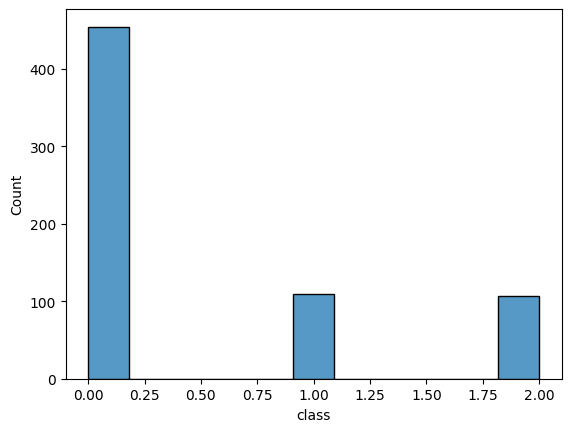

In [57]:
sns.histplot(y_train)

<Axes: ylabel='Count'>

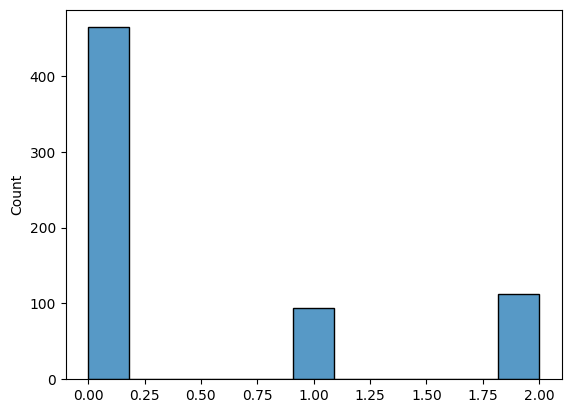

In [45]:
sns.histplot(pd.Series(y_pred_prob))

In [24]:
cross_val_score(cb, X_train, y_train, cv=3, scoring="roc_auc_ovr")
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

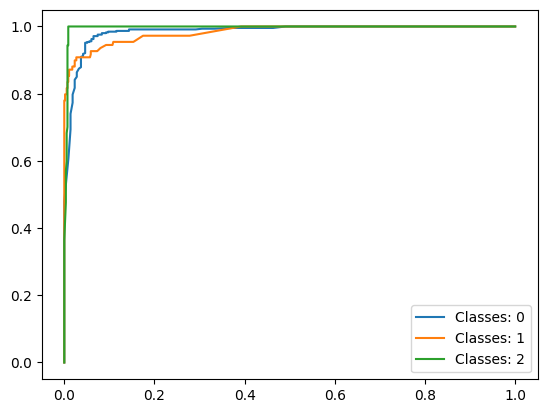

In [25]:
for i in range(n):
        
        fpr, tpr, _ = roc_curve(y_train == i, y_pred_prob[:, i]) 
        roc_auc = auc(fpr, tpr)
        
        fpr_dict[i] = fpr
        tpr_dict[i] = tpr
        roc_auc_dict[i] = roc_auc
        plt.plot(fpr, tpr, label=f'Classes: {i}')
        plt.legend()